In [12]:
import os
import datetime
import glob
import pickle

import numpy as np
import pandas as pd
import scipy


import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations/'

In [2]:
sns.set(palette='muted', context='talk', style='ticks')
scpt = sns.color_palette()

In [42]:
model_df = pd.DataFrame()
files = glob.glob('shelf_model/collected_depths/task*.pickle')
print(files)
for idx, f in enumerate(files):
    tmpdf = pd.DataFrame()
    with open(f, 'rb') as handle:
        tmp = pickle.load(handle)
    
    if idx == 0:
        tmpdf['num_moves'] = pd.Series([t[1] for t in tmp])
    else:
        tmpdf['num_moves'] = pd.Series([t for t in tmp])
        
    
    tmpdf['trial_type'] = f
    model_df = pd.concat([model_df, tmpdf], ignore_index=True)

model_df.trial_type = model_df.trial_type.str.split('\\', expand=True)[1].str.split('.', expand=True)[0]
model_df.trial_type = model_df.trial_type.map({'task1':'easy', 'task2':'hard', 'task3':'hard'})
display(model_df)

['shelf_model/collected_depths\\task1.pickle', 'shelf_model/collected_depths\\task2.pickle', 'shelf_model/collected_depths\\task3.pickle']


,num_moves,trial_type
0,9,easy
1,8,easy
2,10,easy
3,13,easy
4,8,easy
...,...,...
10548,9,hard
10549,9,hard
10550,11,hard
10551,13,hard


In [41]:
samples_df = pd.read_csv(
    '../processed_data/EIH/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
        'subjectID': int, 'trialNum': int, 'trialID': int,
    },
    index_col=False,
)

samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
    'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
    .query('subject_id not in [2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32,70,71) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10592078, 72)
(61, 72)


In [4]:
print(samples_df.columns.to_list())

['timestamp_dt', 'combinedEye_position_x', 'combinedEye_position_y', 'combinedEye_position_z', 'combinedEye_direction_x', 'combinedEye_direction_y', 'combinedEye_direction_z', 'eye_hit', 'combinedEye_raycastHitLocation_x', 'combinedEye_raycastHitLocation_y', 'combinedEye_raycastHitLocation_z', 'nosePointer_position_x', 'nosePointer_position_y', 'nosePointer_position_z', 'nosePointer_direction_x', 'nosePointer_direction_y', 'nosePointer_direction_z', 'nosePointer_raycastHitObject', 'nosePointer_raycastHitLocation_x', 'nosePointer_raycastHitLocation_y', 'nosePointer_raycastHitLocation_z', 'handData_transform_position_x', 'handData_transform_position_y', 'handData_transform_position_z', 'handData_transform_rotation_x', 'handData_transform_rotation_y', 'handData_transform_rotation_z', 'handData_transform_rotation_w', 'handData_transform_scale_x', 'handData_transform_scale_y', 'handData_transform_scale_z', 'unixTimestamp_seconds', 'grasp', 'handData_contactPoint_x', 'handData_contactPoint_y

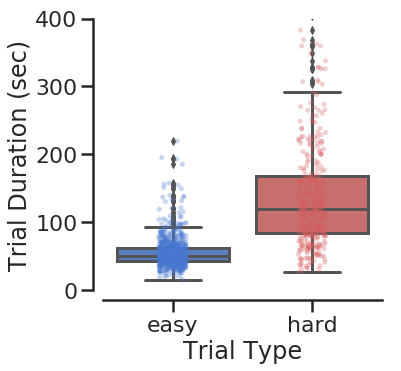

In [5]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
        rc={'font.size':30, 'font.sans-serif':'DejaVu Sans'})
tmpdf = (
    samples_df
    .set_index('timestamp_dt')
    .groupby(['subject_id','trial_type', 'trial_num'])
    .apply(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's'))
    .rename('trial_duration')
    .reset_index()
)
# display(tmpdf)

sns.set(context = "poster", style="ticks", palette="muted", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
_, ax = plt.subplots(1,1,figsize=(5,5))
sns.boxplot(data=tmpdf, x='trial_type', y='trial_duration', palette = ['b', 'r'])

sns.stripplot(
    data=tmpdf, 
    x='trial_type',
    y='trial_duration', 
    palette = ['b', 'r'], 
    alpha=0.3
)
ax.set_ylim(0, 400)
# plt.xticks(rotation=90, fontsize=15)
plt.ylabel('Trial Duration (sec)')
plt.xlabel('Trial Type')
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/TrialDuration.png', quality=90, bbox_inches='tight')

In [44]:
tmpdf = (
    samples_df
    .groupby(['subject_id', 'trial_num','trial_type',], as_index=False)
    .grasp_onset_bool
    .sum()
    .rename(columns = {'grasp_onset_bool':'num_grasp'})
)
display(tmpdf)
# _, ax = plt.subplots(1,1,figsize=(5,5))

# sns.boxplot(
#     data=tmpdf,
#     x='trial_type',
#     y='num_grasp',
#     palette=['b', 'r'],
#     order=['easy', 'hard']
# )
# sns.stripplot(
#     data=tmpdf,
#     x='trial_type',
#     y='num_grasp',
#     palette=['b', 'r'],
#     order=['easy', 'hard'],
#     alpha=0.3
# )
# ax.set_ylim(0,60)
# # plt.xticks(rotation=90, fontsize=15)
# plt.ylabel('Number of Grasps')
# plt.xlabel('Trial Type')
# sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/grasps.png', quality=90, bbox_inches='tight')

,subject_id,trial_num,trial_type,num_grasp
0,2006,2,hard,10.0
1,2006,3,easy,9.0
2,2006,4,hard,20.0
3,2006,5,easy,15.0
4,2006,6,easy,10.0
...,...,...,...,...
1139,2065,19,hard,16.0
1140,2065,20,easy,10.0
1141,2065,21,easy,8.0
1142,2065,22,easy,10.0


<Figure size 432x288 with 0 Axes>

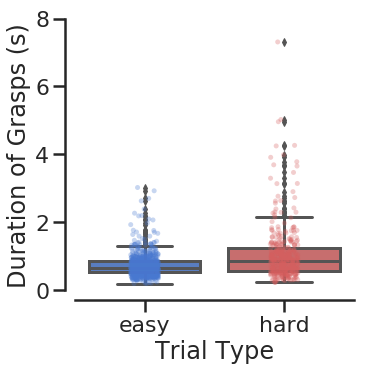

In [10]:
tmpdf = (
    samples_df
    .groupby(['subject_id', 'trial_type','trial_num',], as_index=False)
    .grasp_duration
    .mean()
    .reset_index()
)

_, ax = plt.subplots(1,1,figsize=(5,5))
sns.boxplot(
    data=tmpdf,
    x='trial_type',
    y='grasp_duration',
    palette=['b', 'r'],
    order=['easy', 'hard']
)
sns.stripplot(
    data=tmpdf,
    x='trial_type',
    y='grasp_duration',
    palette=['b', 'r'],
    order=['easy', 'hard'],
    alpha=0.3
)
ax.set_ylim(0,8)
# plt.xticks(rotation=90, fontsize=15)
plt.ylabel('Duration of Grasps (s)')
plt.xlabel('Trial Type')
sns.despine(offset=10)
plt.savefig(PLOT_PATH+'/grasps_duration.png', quality=90, bbox_inches='tight')